In [2]:
# Cell 1: Import necessary libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import  ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.applications import EfficientNetV2B3

In [4]:
# Cell 2: Define constants
BATCH_SIZE = 64
IMG_HEIGHT = 300 
IMG_WIDTH = 300
DATA_DIR = "/home/anon/MajorProject/Data/final_asl_mix"

In [6]:
# Cell 3: Load data

#train and test if already separated
# TRAIN_DATA_DIR = "/home/anon/MajorProject/Data/ASL_MAIN/asl_alphabet_train"
# TEST_DATA_DIR = "/home/anon/MajorProject/Data/Synthetic_Dataset/test"

# train_ds = tf.keras.utils.image_dataset_from_directory(
#     TRAIN_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)

# val_ds = tf.keras.utils.image_dataset_from_directory(
#     TEST_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)


train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 95070 files belonging to 23 classes.
Using 76056 files for training.
Found 95070 files belonging to 23 classes.
Using 19014 files for validation.
['3', '5', 'A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'V', 'X', 'Y', 'space']


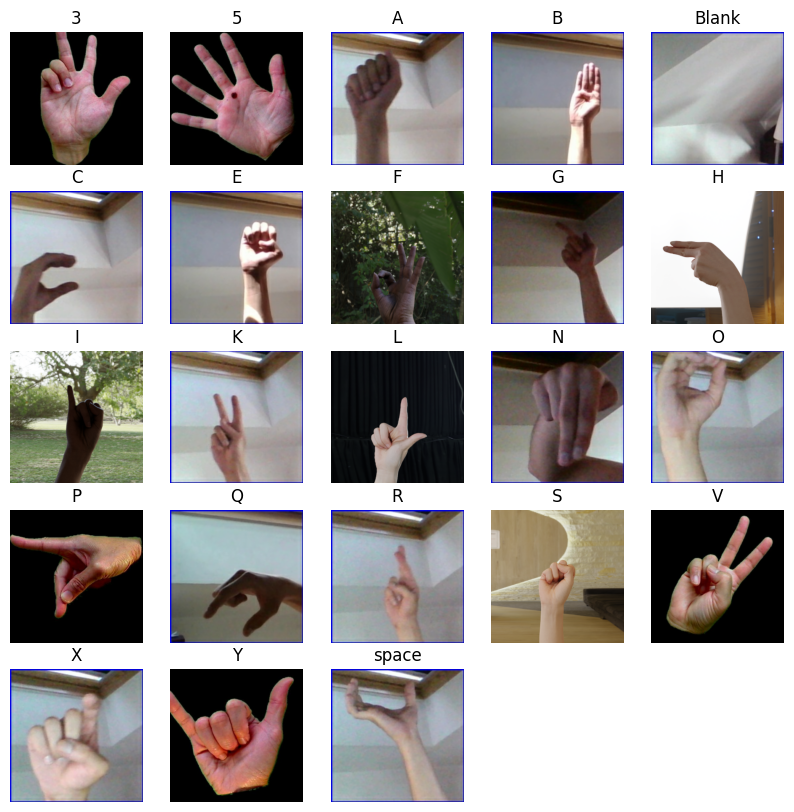

In [7]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Iterate over the images and labels in the current batch
  for image, label in zip(images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")



In [30]:
# Before data augmentation
for images, labels in train_ds.take(1):
  for image in images:
    print(image.shape)


(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


In [8]:
# Cell 4: Define data augmentation
data_augmentation = keras.Sequential(
    [
        # layers.RandomFlip("horizontal"),
        # layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
        # layers.RandomWidth(0.1),
        layers.RandomCrop(IMG_HEIGHT, IMG_HEIGHT),
    ]
)

In [9]:
# Cell 5: Preprocess data #data augmentation and one hot encoding
# train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))
# val_ds = val_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))


#no one hot encoding since class > 10:
# data augmentation
train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y))
val_ds = val_ds.map(lambda x, y: (x, y))

In [10]:
# After data augmentation
for images, labels in train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y)).take(1):
    for image in images:
        print(image.shape)

(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


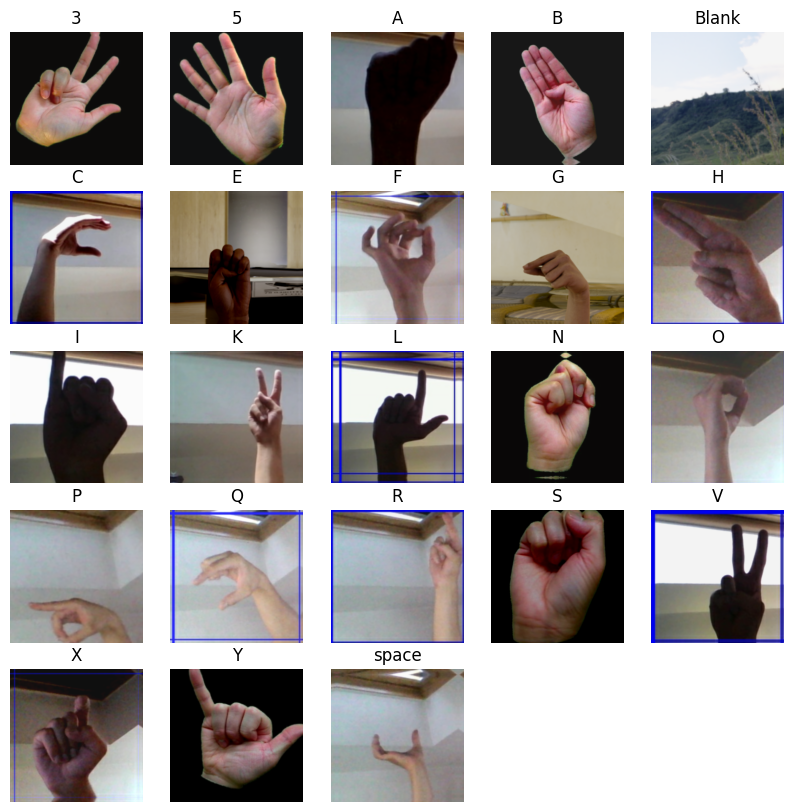

In [11]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Apply data augmentation
  augmented_images = tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), images)
  
  # Iterate over the images and labels in the current batch
  for image, label in zip(augmented_images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")


In [12]:
# Cell 6: Build model
inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model = EfficientNetV2B3(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.5
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization
# outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)  # Removed L2 regularization

# Compile
model = keras.Model(inputs, outputs, name="EfficientNet")
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

In [13]:
for images, labels in train_ds.take(1):
    print(f'Training images shape: {images.shape}, labels shape: {labels.shape}')

for images, labels in val_ds.take(1):
    print(f'Validation images shape: {images.shape}, labels shape: {labels.shape}')


Training images shape: (64, 300, 300, 3), labels shape: (64,)
Validation images shape: (64, 300, 300, 3), labels shape: (64,)


In [14]:
print(model.summary())

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 300, 300, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 300, 300, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 150, 150, 40)         1080      ['normalization[0][

In [15]:
# Cell 7: Define callbacks
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_filepath = '/home/anon/MajorProject/Non_Git/Checkpoints/final/checkpoint-{epoch:02d}-{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

In [17]:
#Cell 8 train the model
epochs = 15
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint,reduce_lr])

Epoch 1/15
1189/1189 [==============================] - ETA: 0s - loss: 2.7070 - accuracy: 0.3693 - sparse_categorical_accuracy: 0.3693 - sparse_top_k_categorical_accuracy: 0.7017

/home/anon/miniconda3/envs/major_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1189/1189 [==============================] - 171s 143ms/step - loss: 2.7070 - accuracy: 0.3693 - sparse_categorical_accuracy: 0.3693 - sparse_top_k_categorical_accuracy: 0.7017 - val_loss: 1.2353 - val_accuracy: 0.7901 - val_sparse_categorical_accuracy: 0.7901 - val_sparse_top_k_categorical_accuracy: 0.9595 - lr: 9.8666e-05
Epoch 2/15
1189/1189 [==============================] - 172s 145ms/step - loss: 1.6655 - accuracy: 0.6067 - sparse_categorical_accuracy: 0.6067 - sparse_top_k_categorical_accuracy: 0.8935 - val_loss: 0.9086 - val_accuracy: 0.8605 - val_sparse_categorical_accuracy: 0.8605 - val_sparse_top_k_categorical_accuracy: 0.9766 - lr: 9.7437e-05
Epoch 3/15
1189/1189 [==============================] - 170s 143ms/step - loss: 1.3384 - accuracy: 0.6879 - sparse_categorical_accuracy: 0.6879 - sparse_top_k_categorical_accuracy: 0.9306 - val_loss: 0.7635 - val_accuracy: 0.8918 - val_sparse_categorical_accuracy: 0.8918 - val_sparse_top_k_categorical_accuracy: 0.9840 - lr: 9.6224e-05


2024-02-20 20:43:39.361748: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1188/1189 [============================>.] - ETA: 0s - loss: 0.8837 - accuracy: 0.8019 - sparse_categorical_accuracy: 0.8019 - sparse_top_k_categorical_accuracy: 0.9714

2024-02-20 20:46:03.500124: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1189/1189 [==============================] - 168s 141ms/step - loss: 0.8837 - accuracy: 0.8019 - sparse_categorical_accuracy: 0.8019 - sparse_top_k_categorical_accuracy: 0.9714 - val_loss: 0.5224 - val_accuracy: 0.9373 - val_sparse_categorical_accuracy: 0.9373 - val_sparse_top_k_categorical_accuracy: 0.9935 - lr: 8.7048e-05
Epoch 12/15
   1/1189 [..............................] - ETA: 4:29 - loss: 1.0180 - accuracy: 0.8125 - sparse_categorical_accuracy: 0.8125 - sparse_top_k_categorical_accuracy: 0.9688

2024-02-20 20:46:27.271373: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-20 20:46:27.321070: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1189/1189 [==============================] - 168s 141ms/step - loss: 0.8773 - accuracy: 0.8022 - sparse_categorical_accuracy: 0.8022 - sparse_top_k_categorical_accuracy: 0.9705 - val_loss: 0.5173 - val_accuracy: 0.9380 - val_sparse_categorical_accuracy: 0.9380 - val_sparse_top_k_categorical_accuracy: 0.9935 - lr: 8.5965e-05
Epoch 13/15
   1/1189 [..............................] - ETA: 4:24 - loss: 0.8156 - accuracy: 0.8281 - sparse_categorical_accuracy: 0.8281 - sparse_top_k_categorical_accuracy: 1.0000

2024-02-20 20:49:15.352220: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1188/1189 [============================>.] - ETA: 0s - loss: 0.8681 - accuracy: 0.8052 - sparse_categorical_accuracy: 0.8052 - sparse_top_k_categorical_accuracy: 0.9714

2024-02-20 20:51:40.069501: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1189/1189 [==============================] - 169s 142ms/step - loss: 0.8682 - accuracy: 0.8051 - sparse_categorical_accuracy: 0.8051 - sparse_top_k_categorical_accuracy: 0.9714 - val_loss: 0.5090 - val_accuracy: 0.9396 - val_sparse_categorical_accuracy: 0.9396 - val_sparse_top_k_categorical_accuracy: 0.9940 - lr: 8.4894e-05
Epoch 14/15
   1/1189 [..............................] - ETA: 4:28 - loss: 1.0757 - accuracy: 0.7188 - sparse_categorical_accuracy: 0.7188 - sparse_top_k_categorical_accuracy: 0.9531

2024-02-20 20:52:04.020819: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-20 20:52:04.070279: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1188/1189 [============================>.] - ETA: 0s - loss: 0.8612 - accuracy: 0.8046 - sparse_categorical_accuracy: 0.8046 - sparse_top_k_categorical_accuracy: 0.9720

2024-02-20 20:54:28.770973: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1189/1189 [==============================] - 168s 142ms/step - loss: 0.8612 - accuracy: 0.8046 - sparse_categorical_accuracy: 0.8046 - sparse_top_k_categorical_accuracy: 0.9720 - val_loss: 0.5057 - val_accuracy: 0.9387 - val_sparse_categorical_accuracy: 0.9387 - val_sparse_top_k_categorical_accuracy: 0.9940 - lr: 8.3838e-05
Epoch 15/15
   1/1189 [..............................] - ETA: 4:29 - loss: 1.0870 - accuracy: 0.7500 - sparse_categorical_accuracy: 0.7500 - sparse_top_k_categorical_accuracy: 0.9688

2024-02-20 20:54:52.612856: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1188/1189 [============================>.] - ETA: 0s - loss: 0.8602 - accuracy: 0.8049 - sparse_categorical_accuracy: 0.8049 - sparse_top_k_categorical_accuracy: 0.9720

2024-02-20 20:57:18.297335: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1189/1189 [==============================] - 170s 143ms/step - loss: 0.8603 - accuracy: 0.8049 - sparse_categorical_accuracy: 0.8049 - sparse_top_k_categorical_accuracy: 0.9720 - val_loss: 0.5017 - val_accuracy: 0.9413 - val_sparse_categorical_accuracy: 0.9413 - val_sparse_top_k_categorical_accuracy: 0.9942 - lr: 8.2794e-05


In [18]:
# Cell 10: Save the model
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetV2B3_300x300_final_asl_mix_FEB_20_has_3_K_REMOVED_W_batch_size_64.h5')
['3', '5', 'A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'V', 'X', 'Y', 'space']


['3',
 '5',
 'A',
 'B',
 'Blank',
 'C',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'V',
 'X',
 'Y',
 'space']

In [19]:
#for categorical_crossentropy
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)


#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


2024-02-20 20:58:28.701499: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 2s 2s/step


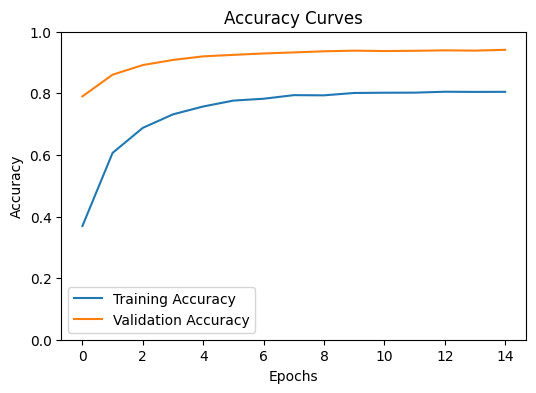

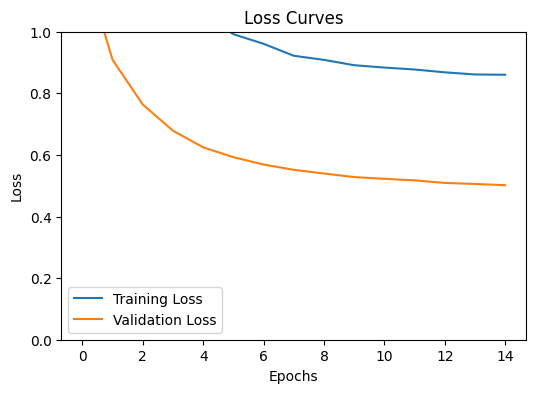

In [20]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()


Class: 3
Precision: 0.9793103448275862
Recall: 1.0
F1 Score: 0.9895470383275261
AUC-ROC: 0.9999205171682917

Class: 5
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC-ROC: 1.0

Class: A
Precision: 0.9510337323177367
Recall: 0.9248677248677248
F1 Score: 0.9377682403433476
AUC-ROC: 0.9611886358026156

Class: B
Precision: 0.9700854700854701
Recall: 0.9763440860215054
F1 Score: 0.9732047159699893
AUC-ROC: 0.987397878003011

Class: Blank
Precision: 0.9838308457711443
Recall: 1.0
F1 Score: 0.9918495297805643
AUC-ROC: 0.9996433079075894

Class: C
Precision: 0.9686800894854586
Recall: 0.9600886917960089
F1 Score: 0.9643652561247216
AUC-ROC: 0.9792713777001245

Class: E
Precision: 0.9462943071965628
Recall: 0.9177083333333333
F1 Score: 0.9317821258593337
AUC-ROC: 0.9574694319818322

Class: F
Precision: 0.9635949943117179
Recall: 0.9474272930648769
F1 Score: 0.9554427523970671
AUC-ROC: 0.9728306443249329

Class: G
Precision: 0.9640644361833953
Recall: 0.8922018348623854
F1 Score: 0.9267421083978559


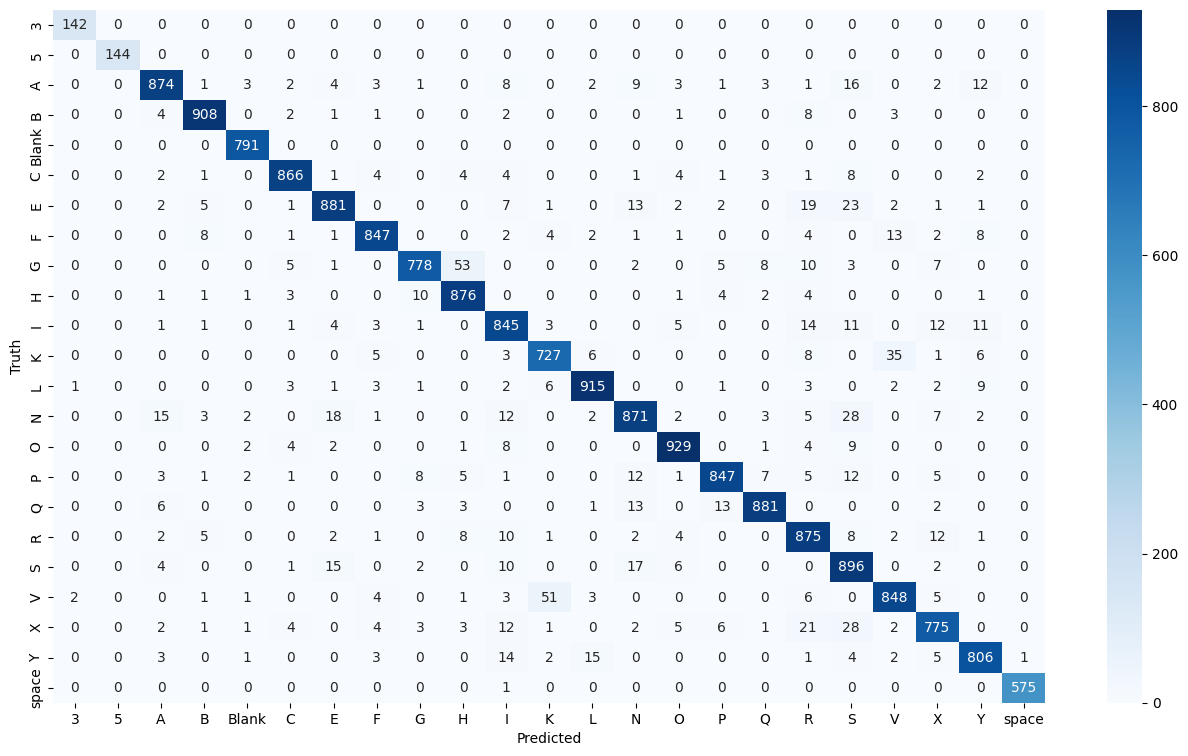

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# AUC-ROC for each class
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=None, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")
    print(f"AUC-ROC: {auc_roc[i]}")
    print()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [23]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block1b_project_conv
10 block1b_project_bn
11 block1b_project_activation
12 block1b_drop
13 block1b_add
14 block2a_expand_conv
15 block2a_expand_bn
16 block2a_expand_activation
17 block2a_project_conv
18 block2a_project_bn
19 block2b_expand_conv
20 block2b_expand_bn
21 block2b_expand_activation
22 block2b_project_conv
23 block2b_project_bn
24 block2b_drop
25 block2b_add
26 block2c_expand_conv
27 block2c_expand_bn
28 block2c_expand_activation
29 block2c_project_conv
30 block2c_project_bn
31 block2c_drop
32 block2c_add
33 block3a_expand_conv
34 block3a_expand_bn
35 block3a_expand_activation
36 block3a_project_conv
37 block3a_project_bn
38 block3b_expand_conv
39 block3b_expand_bn
40 block3b_expand_activation
41 block3b_project_conv
42 block3b_project_bn
43 block3b_drop
44 block3b_add
45 block3c_expand_conv
46 block3c_expand_bn
47 block3c_

In [22]:
# Cell 9: Unfreeze model and continue training
# for layer in model.layers[-20:]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = True

# # we chose to train the top 2 blocks, i.e. we will freeze
# # the first xxx layers and unfreeze the rest:
# for layer in model.layers[:514]:
#    layer.trainable = False
# for layer in model.layers[514:]:
#    layer.trainable = True
# # we need to recompile the model for these modifications to take effect
# # we train our model again (this time fine-tuning the top 2 blocks
# # alongside the top Dense layers
# optimizer = keras.optimizers.Adam(learning_rate=1e-5)
# model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

# epochs = 5
# hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

for layer in model.layers[:410]:
   layer.trainable = False
for layer in model.layers[410:]:
   if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

epochs = 5
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/5


2024-02-20 21:00:31.695933: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-20 21:00:31.784409: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1188/1189 [============================>.] - ETA: 0s - loss: 0.8551 - accuracy: 0.8060 - sparse_categorical_accuracy: 0.8060 - sparse_top_k_categorical_accuracy: 0.9724

2024-02-20 21:02:58.481819: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1189/1189 [==============================] - 177s 143ms/step - loss: 0.8551 - accuracy: 0.8060 - sparse_categorical_accuracy: 0.8060 - sparse_top_k_categorical_accuracy: 0.9724 - val_loss: 0.5014 - val_accuracy: 0.9415 - val_sparse_categorical_accuracy: 0.9415 - val_sparse_top_k_categorical_accuracy: 0.9942
Epoch 2/5
   1/1189 [..............................] - ETA: 4:34 - loss: 0.6593 - accuracy: 0.8594 - sparse_categorical_accuracy: 0.8594 - sparse_top_k_categorical_accuracy: 0.9844

2024-02-20 21:03:22.511101: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1188/1189 [============================>.] - ETA: 0s - loss: 0.8527 - accuracy: 0.8062 - sparse_categorical_accuracy: 0.8062 - sparse_top_k_categorical_accuracy: 0.9729

2024-02-20 21:05:49.335567: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1189/1189 [==============================] - 171s 144ms/step - loss: 0.8527 - accuracy: 0.8063 - sparse_categorical_accuracy: 0.8063 - sparse_top_k_categorical_accuracy: 0.9730 - val_loss: 0.4999 - val_accuracy: 0.9419 - val_sparse_categorical_accuracy: 0.9419 - val_sparse_top_k_categorical_accuracy: 0.9943
Epoch 3/5
   1/1189 [..............................] - ETA: 4:32 - loss: 0.7583 - accuracy: 0.8281 - sparse_categorical_accuracy: 0.8281 - sparse_top_k_categorical_accuracy: 0.9844

2024-02-20 21:06:13.591692: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-20 21:06:13.639839: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1188/1189 [============================>.] - ETA: 0s - loss: 0.8526 - accuracy: 0.8070 - sparse_categorical_accuracy: 0.8070 - sparse_top_k_categorical_accuracy: 0.9727

2024-02-20 21:08:40.310468: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1189/1189 [==============================] - 171s 144ms/step - loss: 0.8525 - accuracy: 0.8070 - sparse_categorical_accuracy: 0.8070 - sparse_top_k_categorical_accuracy: 0.9727 - val_loss: 0.5007 - val_accuracy: 0.9420 - val_sparse_categorical_accuracy: 0.9420 - val_sparse_top_k_categorical_accuracy: 0.9943
Epoch 4/5
   1/1189 [..............................] - ETA: 4:30 - loss: 0.6659 - accuracy: 0.7969 - sparse_categorical_accuracy: 0.7969 - sparse_top_k_categorical_accuracy: 1.0000

2024-02-20 21:09:04.641145: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-20 21:09:04.690623: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1188/1189 [============================>.] - ETA: 0s - loss: 0.8506 - accuracy: 0.8071 - sparse_categorical_accuracy: 0.8071 - sparse_top_k_categorical_accuracy: 0.9735

2024-02-20 21:11:31.279899: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1189/1189 [==============================] - 171s 143ms/step - loss: 0.8507 - accuracy: 0.8071 - sparse_categorical_accuracy: 0.8071 - sparse_top_k_categorical_accuracy: 0.9735 - val_loss: 0.5010 - val_accuracy: 0.9419 - val_sparse_categorical_accuracy: 0.9419 - val_sparse_top_k_categorical_accuracy: 0.9943
Epoch 5/5
   1/1189 [..............................] - ETA: 4:29 - loss: 0.7509 - accuracy: 0.8125 - sparse_categorical_accuracy: 0.8125 - sparse_top_k_categorical_accuracy: 0.9844

2024-02-20 21:11:55.261608: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1189/1189 [==============================] - 169s 142ms/step - loss: 0.8569 - accuracy: 0.8070 - sparse_categorical_accuracy: 0.8070 - sparse_top_k_categorical_accuracy: 0.9714 - val_loss: 0.5002 - val_accuracy: 0.9419 - val_sparse_categorical_accuracy: 0.9419 - val_sparse_top_k_categorical_accuracy: 0.9942


In [23]:
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 2s 2s/step


Class: 3
Precision: 0.9793103448275862
Recall: 1.0
F1 Score: 0.9895470383275261
AUC-ROC: 0.9999205171682917

Class: 5
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC-ROC: 1.0

Class: A
Precision: 0.9491341991341992
Recall: 0.928042328042328
F1 Score: 0.9384697699304441
AUC-ROC: 0.9627205939840839

Class: B
Precision: 0.9711229946524064
Recall: 0.9763440860215054
F1 Score: 0.9737265415549597
AUC-ROC: 0.9874255267532875

Class: Blank
Precision: 0.9838308457711443
Recall: 1.0
F1 Score: 0.9918495297805643
AUC-ROC: 0.9996433079075894

Class: C
Precision: 0.9719416386083053
Recall: 0.9600886917960089
F1 Score: 0.965978806469604
AUC-ROC: 0.9793541957213259

Class: E
Precision: 0.9416135881104034
Recall: 0.9239583333333333
F1 Score: 0.9327024185068349
AUC-ROC: 0.9604559585133488

Class: F
Precision: 0.9666283084004603
Recall: 0.9395973154362416
F1 Score: 0.952921157118548
AUC-ROC: 0.968998436967569

Class: G
Precision: 0.9561510353227771
Recall: 0.9002293577981652
F1 Score: 0.9273479031305375
AUC

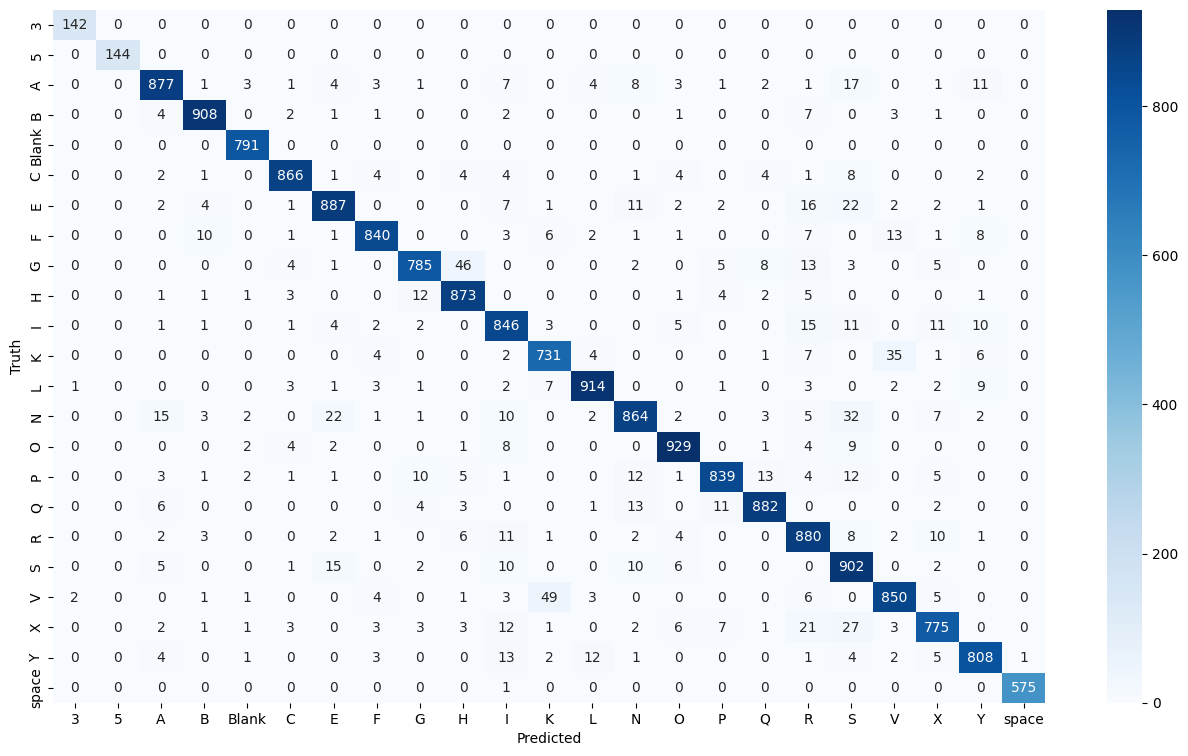

In [24]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.metrics import confusion_matrix, roc_auc_score
# from sklearn.preprocessing import LabelBinarizer
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Accuracy
# accuracy = accuracy_score(y_true, y_pred)

# # Precision, Recall, F1 Score
# average = 'macro'  # or 'micro', 'weighted', depending on the problem
# precision = precision_score(y_true, y_pred, average=average)
# recall = recall_score(y_true, y_pred, average=average)
# f1 = f1_score(y_true, y_pred, average=average)

# # AUC-ROC for multiclass
# lb = LabelBinarizer()
# lb.fit(y_true)
# y_true_lb = lb.transform(y_true)
# y_pred_lb = lb.transform(y_pred)
# auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=average, multi_class='ovr')

# # Confusion Matrix
# cm = confusion_matrix(y_true, y_pred)

# # Print metrics
# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")
# print(f"AUC-ROC: {auc_roc}")

# #for dataset_alpha
# # class_names = ['Brightness_Decrease', 'Brightness_Increase', 'Chrome_Open', 'Cursor_Movement', 'Double_Click', 'Left_Click', 'Nothing', 'PowerPoint_Open', 'Right_Click', 'Screenshot', 'Scroll', 'Shutdown', 'VSCode_Open', 'Volume_Decrease', 'Volume_Increase']


# # class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# # class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# # class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
# # class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
# #for final_asl_mix
# # class_names = ['A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y']

# #feb 20 final
# class_names = ['5', 'A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'V', 'W', 'X', 'Y', 'space']


# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(16,9))
# sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# AUC-ROC for each class
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=None, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")
    print(f"AUC-ROC: {auc_roc[i]}")
    print()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Convert the true and predicted labels to a binary matrix
lb = LabelBinarizer()
lb.fit(y_true)
y_true_bin = lb.transform(y_true)
y_pred_bin = lb.transform(y_pred)

# Calculate the macro-averaged AUC-ROC
auc_roc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC-ROC: {auc_roc_macro}")


Macro-Averaged AUC-ROC: 0.9722465150922632


In [26]:
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetV2B3_300x300_final_asl_mix_FEB_20_has_3_K_and_no_W_batch_size_64_finetuned.h5')

/home/anon/miniconda3/envs/major_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


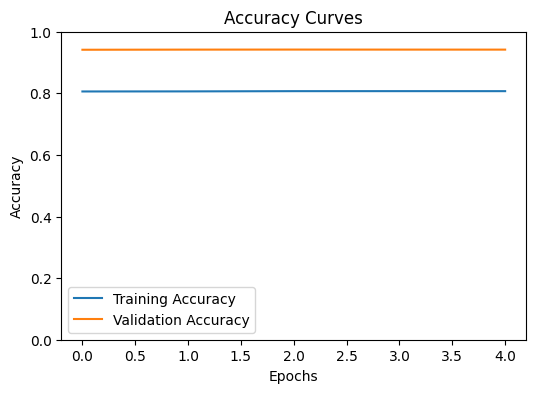

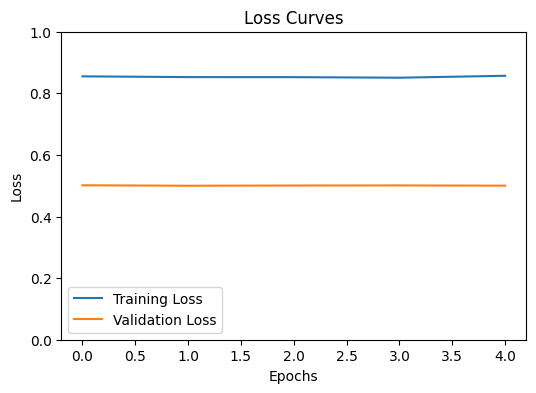

In [27]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()
